# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed all the necessary packages such as [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent
from ReplayBuffer import ReplayBuffer


Next, we will start the environment! Before running the code cell below, change the file_name parameter to match the location of the Unity environment that you downloaded.

- Mac: "path/to/Tennis.app"
- Windows (x86): "path/to/Tennis_Windows_x86/Tennis.exe"
- Windows (x86_64): "path/to/Tennis_Windows_x86_64/Tennis.exe"
- Linux (x86): "path/to/Tennis_Linux/Tennis.x86"
- Linux (x86_64): "path/to/Tennis_Linux/Tennis.x86_64"
- Linux (x86, headless): "path/to/Tennis_Linux_NoVis/Tennis.x86"
- Linux (x86_64, headless): "path/to/Tennis_Linux_NoVis/Tennis.x86_64"

For instance, if you are using a Mac, then you downloaded Tennis.app. If this file is in the same folder as the notebook, then the line below should appear as follows:

env = UnityEnvironment(file_name="Tennis.app")

In [2]:
# insert path.
env = UnityEnvironment(file_name="Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


#### Global Shared Buffer Variables

In [3]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 250        # minibatch size

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents play tennis. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of three sets of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping.

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

Here the multi-agent is trained on Tennis environment. 5000 episodes are considered and if the mean maximum score is equal or greater than 0.5 the training is stopped.

In [6]:
sharedBuffer = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, 0)
agent1 = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=0)
agent2 = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=0)

def ddpg(n_episodes=5000):
    global sharedBuffer
    scores_deque = deque(maxlen=100)
    scores = []
    max_score = -np.Inf
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations 
        agent1.reset()
        agent2.reset()
        score = np.zeros(num_agents)
        while True:
            action1 = agent1.act(states[0])
            action2 = agent2.act(states[1])
            actions = [action1, action2]
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            sharedBuffer.add(states, actions, rewards, next_states, dones)
            agent1.step(sharedBuffer, BATCH_SIZE)
            agent2.step(sharedBuffer, BATCH_SIZE)
            states = next_states
            score += env_info.rewards                         # update the score (for each agent)
            if np.any(dones):
                break
        scores.append(np.max(score))
        scores_deque.append(np.max(score))
        print('\rEpisode {}\tAverage Score: {:.4f}\tScore: {:.4f}'.format(i_episode, np.mean(scores_deque), np.max(score)), end="")
        if i_episode % 100 == 0:
            # save agents
            torch.save(agent1.actor_local.state_dict(), 'checkpoint_actor1.pth')
            torch.save(agent1.critic_local.state_dict(), 'checkpoint_critic1.pth')
            torch.save(agent2.actor_local.state_dict(), 'checkpoint_actor2.pth')
            torch.save(agent2.critic_local.state_dict(), 'checkpoint_critic2.pth')
            if np.mean(np.mean(scores_deque))>=0.5:
                break
            print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_deque)))   
    return scores

scores = ddpg()

c:\python36\lib\site-packages\torch\nn\functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 100	Average Score: 0.0118	Score: 0.0000
Episode 200	Average Score: 0.0010	Score: 0.0000
Episode 300	Average Score: 0.0049	Score: 0.0000
Episode 400	Average Score: 0.0148	Score: 0.0000
Episode 500	Average Score: 0.0118	Score: 0.0000
Episode 600	Average Score: 0.0297	Score: 0.0000
Episode 700	Average Score: 0.0119	Score: 0.0000
Episode 800	Average Score: 0.0644	Score: 0.1000
Episode 900	Average Score: 0.1199	Score: 0.1000
Episode 1000	Average Score: 0.1284	Score: 0.1000
Episode 1100	Average Score: 0.2290	Score: 0.2000
Episode 1200	Average Score: 0.3743	Score: 0.8000
Episode 1300	Average Score: 0.3574	Score: 0.4000
Episode 1400	Average Score: 0.3251	Score: 0.3000
Episode 1500	Average Score: 0.2499	Score: 0.1000
Episode 1600	Average Score: 0.3506	Score: 0.7900
Episode 1700	Average Score: 0.2965	Score: 0.7000
Episode 1800	Average Score: 0.5067	Score: 0.0000

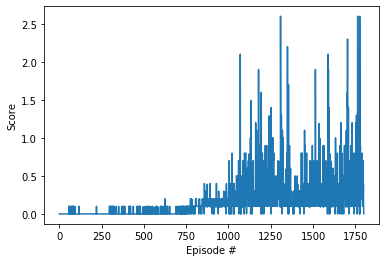

In [7]:
# plot scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Smart Agent performance

In [9]:
# load the weights from file
agent1.actor_local.load_state_dict(torch.load('checkpoint_actor1.pth'))
agent1.critic_local.load_state_dict(torch.load('checkpoint_critic1.pth'))
agent2.actor_local.load_state_dict(torch.load('checkpoint_actor2.pth'))
agent2.critic_local.load_state_dict(torch.load('checkpoint_critic2.pth'))

env_info = env.reset(train_mode=False)[brain_name]
states = env_info.vector_observations 
score = np.zeros(num_agents)
while True:
    action1 = agent1.act(states[0])
    action2 = agent2.act(states[1])
    actions = [action1, action2]
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done
    states = next_states
    score += env_info.rewards                         # update the score (for each agent)
    if np.any(dones):
        break
        
print('Total score (averaged over agents) this episode: {}'.format(np.max(score)))


Total score (averaged over agents) this episode: 1.600000023841858


In [7]:
env.close()